# Implementation of seq2seq Encoder-Decoder
# Chat Bot based on Bidirectional RNN architecture 

### import of libraries


In [1]:
import os
import re
import shutil
import string

import codecs
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.__version__)

2024-01-11 19:24:56.883164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:24:56.883195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:24:56.883200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 19:24:56.887631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
# MAKE CuDNN available for computations
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-11 19:25:00.879043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:25:00.900425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:25:00.904349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Download the dataset

I will use Cornell Movie-Dialogs Corpus for teaching this chat bot.
This corpus contains a metadata-rich collection of fictional conversations extracted from raw movie scripts:

- 220,579 conversational exchanges between 10,292 pairs of movie characters
- involves 9,035 characters from 617 movies
- in total 304,713 utterances
- movie metadata included:
	- genres
	- release year
	- IMDB rating
	- number of IMDB votes
	- IMDB rating
- character metadata included:
	- gender (for 3,774 characters)
	- position on movie credits (3,321 characters)

### Open the .txt tables into Pandas DataFrames

In [3]:
def file_to_np_arr(filename):
# filename = './ChatBot_Dataset/movie_conversations.txt'
    with open(filename) as file:
        lines = [line.rstrip().split(" +++$+++ ") for line in file]

    return np.array(lines)

### open conversations to DataFrame
- movie_conversations.txt
	- the structure of the conversations
	- fields
		- characterID of the first character involved in the conversation
		- characterID of the second character involved in the conversation
		- movieID of the movie in which the conversation occurred
		- list of the utterances that make the conversation, in chronological 
			order: ['lineID1','lineID2',É,'lineIDN']
			has to be matched with movie_lines.txt to reconstruct the actual content

In [4]:
df_conversations = pd.DataFrame(file_to_np_arr('./ChatBot_Dataset/movie_conversations.txt'),
                                columns = ['characterID_1', 'characterID_2', 'movieID', 'conversation_tags'])
df_conversations.head()

,characterID_1,characterID_2,movieID,conversation_tags
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


### open movie lines to DataFrame
- movie_lines.txt
	- contains the actual text of each utterance
	- fields:
		- lineID
		- characterID (who uttered this phrase)
		- movieID
		- character name
		- text of the utterance

In [5]:
# LOAD MOVIE LINES
filename = './ChatBot_Dataset/movie_lines.txt'
counter = 0
lines = list()
with open(filename) as file:
    for line in file:
        counter += 1
        listed = line.rstrip().split(" +++$+++ ") 
        if len(listed) == 5:
            lines.append(listed)
            
df_movie_lines = pd.DataFrame(np.array(lines),
                                columns = ['lineID', 'characterID', 'movieID', 'character name', 'text'])
df_movie_lines.head()

,lineID,characterID,movieID,character name,text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


### open characters metadata to DataFrame
- movie_characters_metadata.txt
	- contains information about each movie character
	- fields:
		- characterID
		- character name
		- movieID
		- movie title
		- gender ("?" for unlabeled cases)
		- position in credits ("?" for unlabeled cases) 

In [6]:
# load movie characters metadata
filename = './ChatBot_Dataset/movie_characters_metadata.txt'
counter = 0
lines = list()
with open(filename) as file:
    for line in file:
        counter += 1
        listed = line.rstrip().split(" +++$+++ ") 
        if len(listed) == 6:
            lines.append(listed)
            
df_movie_characters = pd.DataFrame(np.array(lines),
                                columns = ['characterID', 'character name', 'movieID', 'movie title', 'gender', 'position in credits'])
df_movie_characters.head()

,characterID,character name,movieID,movie title,gender,position in credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


### open movie titles metadata to DataFrame
- movie_titles_metadata.txt
	- contains information about each movie title
	- fields: 
		- movieID, 
		- movie title,
		- movie year, 
	   	- IMDB rating,
		- no. IMDB votes,
 		- genres in the format ['genre1','genre2',É,'genreN']

In [7]:
# load movie  metadata
filename = './ChatBot_Dataset/movie_titles_metadata.txt'
counter = 0
lines = list()
with open(filename) as file:
    for line in file:
        counter += 1
        listed = line.rstrip().split(" +++$+++ ") 
        if len(listed) == 6:
            lines.append(listed)
            
df_movie_titles = pd.DataFrame(np.array(lines),
                                columns = ['movieID', 'movie title', 'movie year', 'IMDB rating', 'no. IMDB votes', 'genres'])
df_movie_titles.head()

,movieID,movie title,movie year,IMDB rating,no. IMDB votes,genres
0,m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.20,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.10,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.40,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.90,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."


In [8]:
# now "genres" column contains all data in string format
# decode Genres from str to list
def f(row):
    # print(row)
    return eval(row)
    

converted_genres = df_movie_titles['genres'].apply(f)
df_movie_titles['converted_genres'] = converted_genres
df_movie_titles.head(3)

,movieID,movie title,movie year,IMDB rating,no. IMDB votes,genres,converted_genres
0,m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']","[comedy, romance]"
1,m1,1492: conquest of paradise,1992,6.20,10421,"['adventure', 'biography', 'drama', 'history']","[adventure, biography, drama, history]"
2,m2,15 minutes,2001,6.10,25854,"['action', 'crime', 'drama', 'thriller']","[action, crime, drama, thriller]"


### I will train the model on the conversations from Action films.
We can make thematic chat bot :)
### Filtering the films with genre "Action"

In [9]:
def f(row):
    return 'action' in row

action_films = df_movie_titles[  df_movie_titles['converted_genres'].apply(f) ]
action_film_tags = action_films.movieID.values
action_film_tags

array(['m2', 'm4', 'm5', 'm11', 'm15', 'm19', 'm22', 'm23', 'm25', 'm33',
       'm37', 'm39', 'm40', 'm48', 'm58', 'm61', 'm65', 'm66', 'm67',
       'm68', 'm74', 'm76', 'm86', 'm89', 'm97', 'm98', 'm99', 'm100',
       'm113', 'm122', 'm125', 'm126', 'm129', 'm133', 'm135', 'm142',
       'm143', 'm157', 'm169', 'm171', 'm180', 'm185', 'm186', 'm188',
       'm189', 'm191', 'm192', 'm193', 'm195', 'm196', 'm197', 'm198',
       'm200', 'm206', 'm210', 'm214', 'm220', 'm221', 'm222', 'm226',
       'm232', 'm237', 'm248', 'm250', 'm259', 'm260', 'm261', 'm262',
       'm271', 'm272', 'm275', 'm282', 'm287', 'm290', 'm291', 'm295',
       'm300', 'm303', 'm309', 'm310', 'm311', 'm319', 'm321', 'm323',
       'm325', 'm328', 'm333', 'm335', 'm337', 'm339', 'm343', 'm345',
       'm351', 'm356', 'm357', 'm366', 'm367', 'm371', 'm377', 'm388',
       'm389', 'm392', 'm394', 'm409', 'm410', 'm411', 'm418', 'm420',
       'm429', 'm430', 'm433', 'm437', 'm442', 'm443', 'm454', 'm456',
    

### Filtering the Dialogues with 2 conversation tags only. Supposed that here will be "Question - Answer" chains


In [10]:
def two_replics(conv_tags):
    return len(eval(conv_tags)) == 2

filtered_replics = df_conversations[ (df_conversations['movieID'].isin(action_film_tags)) & (df_conversations['conversation_tags'].apply(two_replics))]
filtered_replics

,characterID_1,characterID_2,movieID,conversation_tags
301,u26,u30,m2,"['L3496', 'L3497']"
302,u26,u30,m2,"['L3545', 'L3546']"
306,u27,u34,m2,"['L3096', 'L3097']"
314,u27,u34,m2,"['L3313', 'L3314']"
316,u27,u34,m2,"['L3329', 'L3330']"
...,...,...,...,...
83087,u9027,u9029,m616,"['L666460', 'L666461']"
83088,u9027,u9029,m616,"['L666485', 'L666486']"
83089,u9027,u9029,m616,"['L666546', 'L666547']"
83093,u9028,u9031,m616,"['L666575', 'L666576']"


### Now let's convert the conversation_tags into String form and split them by 2 columns. 
### To Speaker_1 and Speaker_2

In [11]:
def split_replics(row):
    
    row = eval(row.conversation_tags)

    try:
        speaker_1 = df_movie_lines[df_movie_lines['lineID'] == row[0]]['text'].values[0]
    except IndexError:
        speaker_1 = None
        
    try:
        speaker_2 = df_movie_lines[df_movie_lines['lineID'] == row[1]]['text'].values[0]
    except IndexError:
        speaker_2 = None

    return  speaker_1,  speaker_2

# tmp = filtered_replics.head(5)
# tmp

filtered_replics[['speaker_1', 'speaker_2']] = filtered_replics.apply(split_replics, axis=1, result_type ='expand')

/tmp/ipykernel_27961/983116085.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_replics[['speaker_1', 'speaker_2']] = filtered_replics.apply(split_replics, axis=1, result_type ='expand')
/tmp/ipykernel_27961/983116085.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_replics[['speaker_1', 'speaker_2']] = filtered_replics.apply(split_replics, axis=1, result_type ='expand')


### Check if we got any "NaN" or "None" values, and filter them

In [12]:
filtered_replics.shape

(10046, 6)

In [13]:
filtered_replics = filtered_replics.dropna()
filtered_replics.shape

(10006, 6)

In [14]:
filtered_replics.isna().sum()

characterID_1        0
characterID_2        0
movieID              0
conversation_tags    0
speaker_1            0
speaker_2            0
dtype: int64

In [15]:
filtered_replics.head(3)

,characterID_1,characterID_2,movieID,conversation_tags,speaker_1,speaker_2
301,u26,u30,m2,"['L3496', 'L3497']",I'm abused. Don't you think?,"I don't think it's abuse, I think it's torture."
302,u26,u30,m2,"['L3545', 'L3546']",...so we kill someone famous and if we are cau...,"Officers, there's your killer, do your duty, a..."
306,u27,u34,m2,"['L3096', 'L3097']",I can't take you to my place.,Somewhere else?


### Whis model will generate output in "character by character" mode

In [32]:
# symbolic chains of the speaker_1
input_texts = list(filtered_replics.speaker_1.values) 
input_texts[0]

"I'm abused.  Don't you think?"

In [33]:
# symbolic chains of the speaker_2
target_texts = list(filtered_replics.speaker_2.values)
target_texts[0]

"I don't think it's abuse, I think it's torture."

### Let's have a look at lengths of target symbolic chains

(array([  0.,   1.,   0.,  49.,  88., 177., 117., 147., 181., 183., 211.,
        156., 146., 176., 168., 189., 163., 162., 170., 167., 169., 153.,
        174., 158., 173., 160., 148., 150., 148., 153., 149., 158., 135.,
        137., 146., 135., 111., 114., 119.,  90.,  90.,  92.,  89., 120.,
         98., 100., 101.,  78.,  80.,  82.,  93.,  61.,  87.,  65.,  65.,
         69.,  70.,  73.,  79.,  68.,  63.,  76.,  59.,  58.,  47.,  47.,
         52.,  55.,  50.,  61.,  54.,  43.,  35.,  34.,  35.,  52.,  44.,
         39.,  30.,  45.,  34.,  29.,  31.,  32.,  31.,  32.,  44.,  27.,
         34.,  29.,  24.,  33.,  23.,  28.,  22.,  27.,  24.,  33.,  45.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58

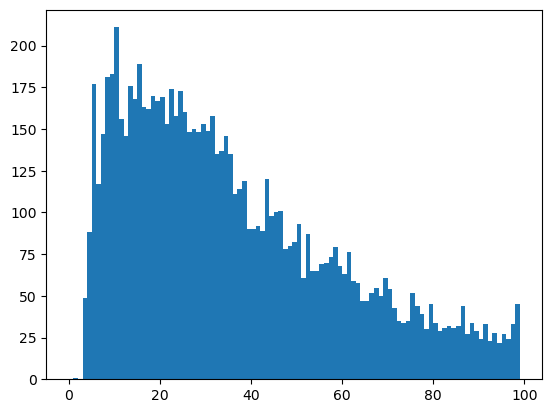

In [34]:
# Оценим длины выходных цепочек
seq_length =np.array([len(seq) for seq in target_texts])
plt.hist(seq_length, bins = list(range(0, 100,  1)))

### We can see the symbolic chains length distribution and length of symbolic chain can vary.
But we will use chains of fixed length to train our model. 
That mean we will use "Padding" - filling the rest of short symbolic chain with " " - symbol.
### Important
Using the symbolic chains with the Vast majority of Padding character " " could cause a problem:
Model could generate the sequences of Padding characters, where is no sence.
### I will filter only the character-chains where length is not vary too much

In [35]:
limit_75 = np.percentile(seq_length, 75)
limit_25 = np.percentile(seq_length, 25)
indices = np.argwhere((seq_length>limit_25) & (seq_length < limit_75))
print('limit_25', limit_25)
print('limit_75', limit_75)

limit_25 19.0
limit_75 65.0


In [3]:
print('the number of symbolic chains was:', len(input_texts))

the number of symbolic chains was: 10006


In [37]:
# filtering of input and target symbolic chains from indices we've got above
input_texts = np.take(input_texts, indices)
target_texts = np.take(target_texts, indices)

In [4]:
print('the number of symbolic chains after filtering:', len(target_texts))

the number of symbolic chains after filtering: 4843


In [39]:
# convert back to LIST type
input_texts = [str(elem[0]) for elem in input_texts]
target_texts = [str(elem[0]) for elem in target_texts]

### Creation of vocabulary
we nee to get the list of unique characters from whole texts (speaker_1 + speaker_2)

In [40]:
all_texts = ' '.join(input_texts) + ' ' + ' '.join(target_texts)
splitted_all_text = list(all_texts)

In [42]:
vocab = sorted(set(splitted_all_text))
vocab.append('<START>')
vocab.append('<END>')
vocab.append(' ')
vocab_size = len(vocab)
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
print('vocab_size: ', vocab_size)

vocab_size:  91


### Preparation of Datasets

In [45]:
input_texts_as_int = [[char2idx[w] for w in text] for text in input_texts]
target_texts_as_int = [[char2idx[w] for w in text] for text in target_texts]

encoder_input_seqs = [np.array(text) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([char2idx['<START>']] + target_text))
    decoder_target_seqs.append(np.array(target_text + [char2idx['<END>']]))

In [46]:
print([idx2char[idx] for idx in  decoder_input_seqs[0]])

['<START>', 'I', ' ', 'd', 'o', 'n', "'", 't', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 'a', 'b', 'u', 's', 'e', ',', ' ', 'I', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 't', 'o', 'r', 't', 'u', 'r', 'e', '.']


In [47]:
print([idx2char[idx] for idx in  decoder_target_seqs[0]])

['I', ' ', 'd', 'o', 'n', "'", 't', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 'a', 'b', 'u', 's', 'e', ',', ' ', 'I', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 't', 'o', 'r', 't', 'u', 'r', 'e', '.', '<END>']


In [48]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])
print('max_enc_seq_length: ', max_enc_seq_length)
print('max_dec_seq_length: ', max_dec_seq_length)

max_enc_seq_length:  524
max_dec_seq_length:  65


### Make the Padding of chains
Make all chains the equal length, filling gaps with char2idx[' '] symbol.

In [49]:
max_enc_seq_length = 65
max_dec_seq_length = 65

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=char2idx[' '],
    padding='post',
    maxlen=max_enc_seq_length)

decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_seqs,
    value=char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length)

In [51]:
print([idx2char[idx] for idx in  encoder_input_seqs[0]])

['I', "'", 'm', ' ', 'a', 'b', 'u', 's', 'e', 'd', '.', ' ', ' ', 'D', 'o', 'n', "'", 't', ' ', 'y', 'o', 'u', ' ', 't', 'h', 'i', 'n', 'k', '?', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [52]:
print([idx2char[idx] for idx in  decoder_input_seqs[0]])

['<START>', 'I', ' ', 'd', 'o', 'n', "'", 't', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 'a', 'b', 'u', 's', 'e', ',', ' ', 'I', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 't', 'o', 'r', 't', 'u', 'r', 'e', '.', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [53]:
print([idx2char[idx] for idx in  decoder_target_seqs[0]])

['I', ' ', 'd', 'o', 'n', "'", 't', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 'a', 'b', 'u', 's', 'e', ',', ' ', 'I', ' ', 't', 'h', 'i', 'n', 'k', ' ', 'i', 't', "'", 's', ' ', 't', 'o', 'r', 't', 'u', 'r', 'e', '.', '<END>', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


### Creation of the model

In [54]:
INPUT_VOCAB_SIZE = vocab_size
TARGET_VOCAB_SIZE = vocab_size

H_SIZE = 256   #64 # size of the hidden state of LSTM
EMB_SIZE = H_SIZE * 2  # size of input embedding

class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(INPUT_VOCAB_SIZE, EMB_SIZE)
        self.lstm1 = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True,  recurrent_dropout=0.000001, name = 'encoder1'),
            merge_mode="concat"
        )
        
        self.lstm2 =  tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(H_SIZE, return_sequences=False, return_state=True, recurrent_dropout=0.000001, name = 'encoder2'),
            merge_mode="concat"
        )
        
        
    def call(self, x):
        out = self.embed(x)
        out, h_fwd_1, c_fwd_1, h_bwd_1, c_bwd_1 = self.lstm1(out)               
        out, h_fwd_2, c_fwd_2, h_bwd_2, c_bwd_2 = self.lstm2(out)

        h_1 = tf.keras.layers.Concatenate()([h_fwd_1, h_bwd_1])
        c_1 = tf.keras.layers.Concatenate()([c_fwd_1, c_bwd_1])
        h_2 = tf.keras.layers.Concatenate()([h_fwd_2, h_bwd_2])
        c_2 = tf.keras.layers.Concatenate()([c_fwd_2, c_bwd_2])  

        state1 = [h_1, c_1]
        state2 = [h_2, c_2]

        return state1 , state2

class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(TARGET_VOCAB_SIZE, EMB_SIZE)

        self.lstm1 = tf.keras.layers.LSTM(2*H_SIZE, return_sequences=True, return_state=True, recurrent_dropout=0.000001, name = 'decoder1')
        self.lstm2 = tf.keras.layers.LSTM(2*H_SIZE, return_sequences=True, return_state=True, recurrent_dropout=0.000001, name = 'decoder2')
        self.fc = tf.keras.layers.Dense(TARGET_VOCAB_SIZE, activation='softmax')

    def call(self, x, init_state1, init_state2):
        out = self.embed(x)
        
        out, h_1, c_1 = self.lstm1(out, initial_state=init_state1)        
        out, h_2, c_2 = self.lstm1(out, initial_state=init_state2)
        out = self.fc(out)
        state1 = [h_1, c_1]
        state2 = [h_2, c_2]
        
        return out, state1, state2

encoder_model = Encoder()
decoder_model = Decoder()

encoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_inputs = tf.keras.layers.Input(shape=(None,))

enc_state1,  enc_state2 = encoder_model(encoder_inputs)
decoder_outputs, _ , _ = decoder_model(decoder_inputs, enc_state1, enc_state2)

seq2seq = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

2024-01-11 19:37:39.837622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:37:39.842181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 19:37:39.845814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Training the model

In [62]:
BATCH_SIZE = 64
EPOCHS = 100

loss = tf.losses.SparseCategoricalCrossentropy()
seq2seq.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])
seq2seq.fit([encoder_input_seqs, decoder_input_seqs], decoder_target_seqs,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

Epoch 1/100
76/76 [==============================] - 51s 552ms/step - loss: 0.1313 - accuracy: 0.9627
Epoch 2/100
76/76 [==============================] - 41s 537ms/step - loss: 0.1265 - accuracy: 0.9638
Epoch 3/100
76/76 [==============================] - 41s 537ms/step - loss: 0.1235 - accuracy: 0.9648
Epoch 4/100
76/76 [==============================] - 41s 533ms/step - loss: 0.1216 - accuracy: 0.9653
Epoch 5/100
76/76 [==============================] - 41s 539ms/step - loss: 0.1189 - accuracy: 0.9661
Epoch 6/100
76/76 [==============================] - 41s 535ms/step - loss: 0.1168 - accuracy: 0.9668
Epoch 7/100
76/76 [==============================] - 41s 536ms/step - loss: 0.1232 - accuracy: 0.9657
Epoch 8/100
76/76 [==============================] - 41s 536ms/step - loss: 0.1128 - accuracy: 0.9679
Epoch 9/100
76/76 [==============================] - 41s 541ms/step - loss: 0.1097 - accuracy: 0.9688
Epoch 10/100
76/76 [==============================] - 41s 541ms/step - loss: 0.107

In [63]:
def seq2seq_inference(input_seq):
    state1, state2 = encoder_model(input_seq)

    target_seq = np.array([[char2idx['<START>']]])

    decoded_sentence = ''
    while True:
        output_tokens, state1, state2 = decoder_model(target_seq, state1, state2)

        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_char = idx2char[sampled_token_index]
        
        decoded_sentence += sampled_char

        if (sampled_char == '<END>' or len(decoded_sentence) > 100):
            break

        target_seq = np.array([[sampled_token_index]])

    return decoded_sentence

 ### Define the function of user inference

In [68]:
def user_inference(user_text):
    user_seq = np.array([[char2idx[c] for c in user_text]], dtype='int32')
    decoded_sentence = seq2seq_inference(user_seq)
    print('-')
    print('Input sentence:', user_text)
    print('Result sentence:', decoded_sentence)

-
Input sentence: Let's test what you have learned
Result sentence: He's a moming big ling.sse fat anything.<END>


### Let's make some tests...

In [78]:
user_inference("Hello! Show me please what have you learned today!")

-
Input sentence: Hello! Show me please what have you learned today!
Result sentence: I don't care.  Hank.<END>


In [82]:
user_inference("tell me about yourself")

-
Input sentence: tell me about yourself
Result sentence: I don't think so, Detective ...<END>


In [83]:
user_inference("it is up to you actually. But I suppose that would be better for you if you speak")

-
Input sentence: it is up to you actually. But I suppose that would be better for you if you speak
Result sentence: Yeah.  Yeah, that'll work.<END>


In [84]:
user_inference("great! So who have yo spoken with before I come?")

-
Input sentence: great! So who have yo spoken with before I come?
Result sentence: I was just thinking that.<END>


In [85]:
user_inference("Could you finish your every sentence please? As I see you are not going to speak a lot today, right?")

-
Input sentence: Could you finish your every sentence please? As I see you are not going to speak a lot today, right?
Result sentence: What are they doing in the middle of nowhere?<END>


In [86]:
user_inference("Who you are speaking about?")

-
Input sentence: Who you are speaking about?
Result sentence: You don't set money.<END>


In [88]:
user_inference("I did, you forgot right?")

-
Input sentence: I did, you forgot right?
Result sentence: The door.  Let get one of the beat.<END>
